# Aula 5

In [12]:
import pandas as pd
from func import Modelo_prophet_semanal
import matplotlib.pyplot as plt

In [22]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dados_sp = pd.read_csv('dados/dados_covid_sp', parse_dates=['datahora'])

In [3]:
df = dados_sp[['datahora', 'casos_novos']]
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2020-02-25,0
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,1
4,2020-02-29,0


In [4]:
feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]

#Adicionando as listas ao DataFrame 
feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021)) #união das informações

In [5]:
modelo_com_outliers = Modelo_prophet_semanal(df, changepoint_prior_scale=10, seasonality_mode='multiplicative', holidays=feriados, interval_width=0.95)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


#### Eliminar dados fora do intervalo de confiança de 95%(outliers)

In [6]:
treino = modelo_com_outliers.treino.reset_index()
df_sem_outliers = treino[(treino['y'] > modelo_com_outliers.previsao.yhat_lower[:len(treino)])&(treino['y'] < modelo_com_outliers.previsao.yhat_upper[:len(treino)])]
modelo_com_outliers = Modelo_prophet_semanal(df_sem_outliers.append(modelo_com_outliers.teste), changepoint_prior_scale=10, seasonality_mode='multiplicative', holidays=feriados, interval_width=0.95)

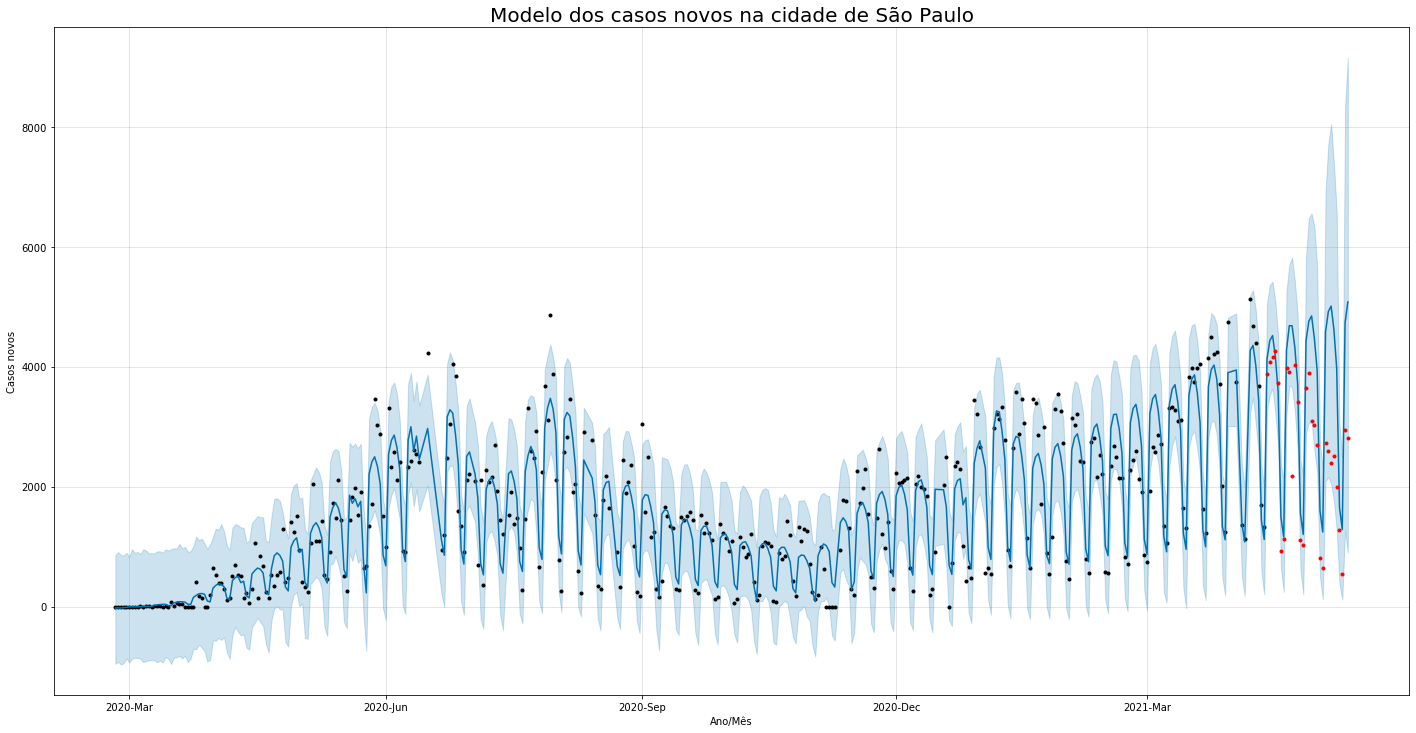

In [15]:
modelo_com_outliers.plota(xlabel='Ano/Mês', ylabel='Casos novos', kwargs_testeplot={'marker':'.', 'color':'red'})
plt.title('Modelo dos casos novos na cidade de São Paulo', fontsize=20)
plt.show()

## Desafio 13: Testar diferentes intervalos de confiança.

In [40]:
class Modelo_prophet_semanal:
    
    def __init__(self, dados:pd.DataFrame, teste_periodo=30, **kwargs_model):
        
        self.treino = dados[:len(dados) - teste_periodo]
        self.teste = dados[len(dados) - teste_periodo:]
        self.modelo = Prophet(daily_seasonality=False, yearly_seasonality=False, **kwargs_model)
        self.modelo.fit(self.treino)
        self.previsao = self.modelo.predict(self.modelo.make_future_dataframe(periods=teste_periodo))
    
    def plota(self, xlabel='', ylabel='', teste=True, changepoint=False, ax=None, show=False, month_freq=3, kwargs_modeloplot={}, kwargs_testeplot={}, linestyle=''):
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(20,10))
            ax_none = True
        
        plt.sca(ax)
        self.modelo.plot(self.previsao, xlabel=xlabel, ylabel=ylabel, ax=ax, **kwargs_modeloplot)
        plt.plot(self.teste['ds'], self.teste['y'], linestyle = linestyle, **kwargs_testeplot)
        
        if len(self.teste) > 0:
            plt.xticks(pd.date_range(min(self.treino['ds']), max(self.teste['ds']), freq=f'{month_freq}MS'),pd.date_range(min(self.treino['ds']), max(self.teste['ds']), freq=f'{month_freq}MS').strftime('%Y-%b'))
        else:
            plt.xticks(pd.date_range(min(self.treino['ds']), max(self.treino['ds']), freq=f'{month_freq}MS'),pd.date_range(min(self.treino['ds']), max(self.treino['ds']), freq=f'{month_freq}MS').strftime('%Y-%b'))
        
        if changepoint is True:
            change = add_changepoints_to_plot(ax, self.modelo, self.previsao)
    
        if show is True:
            plt.show()
            
        elif ax_none is True:
            return fig

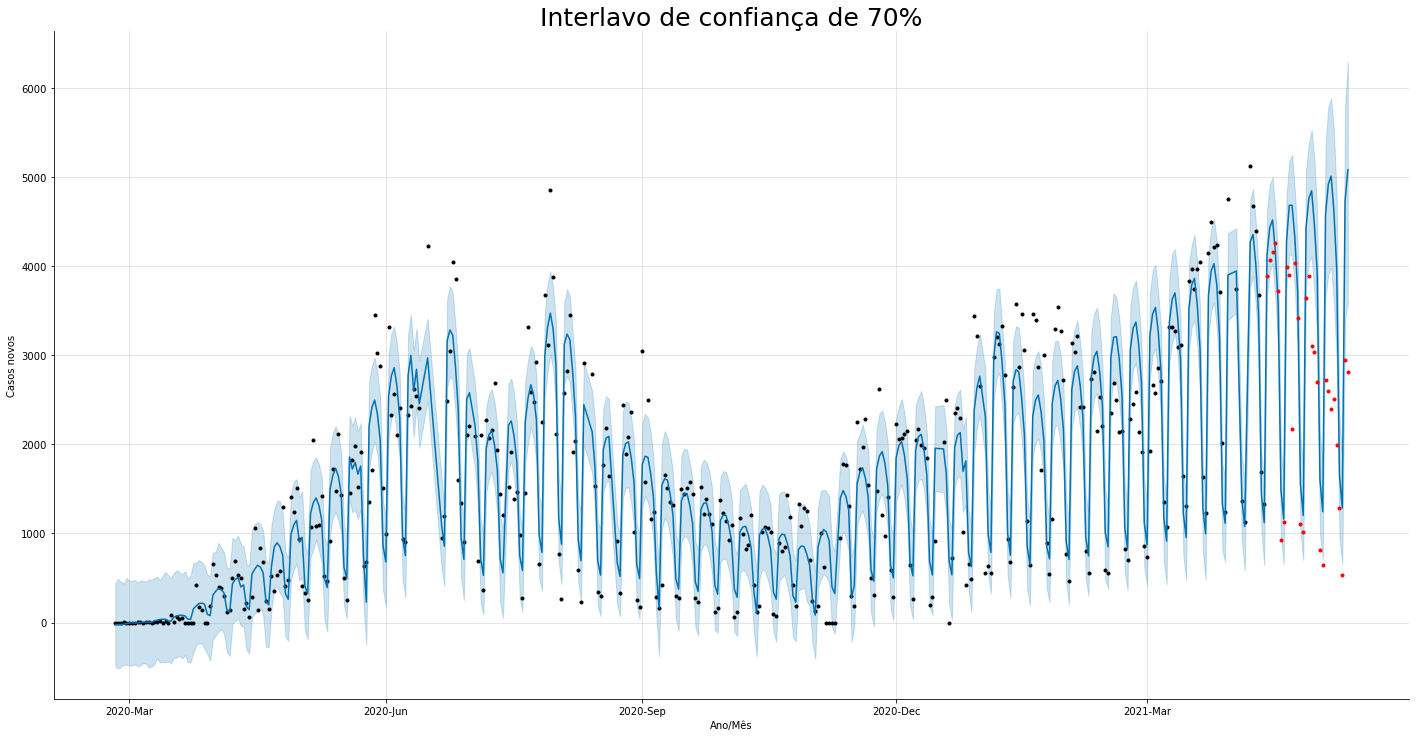

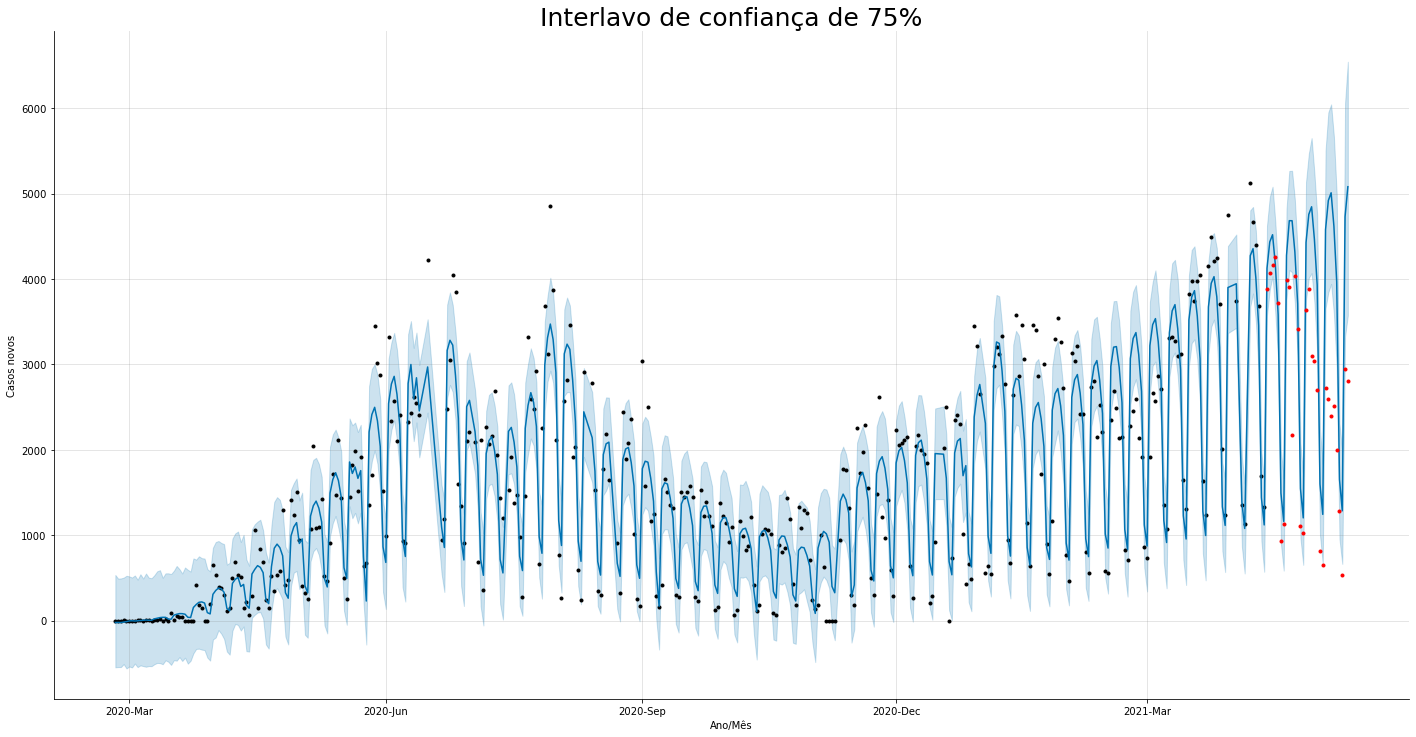

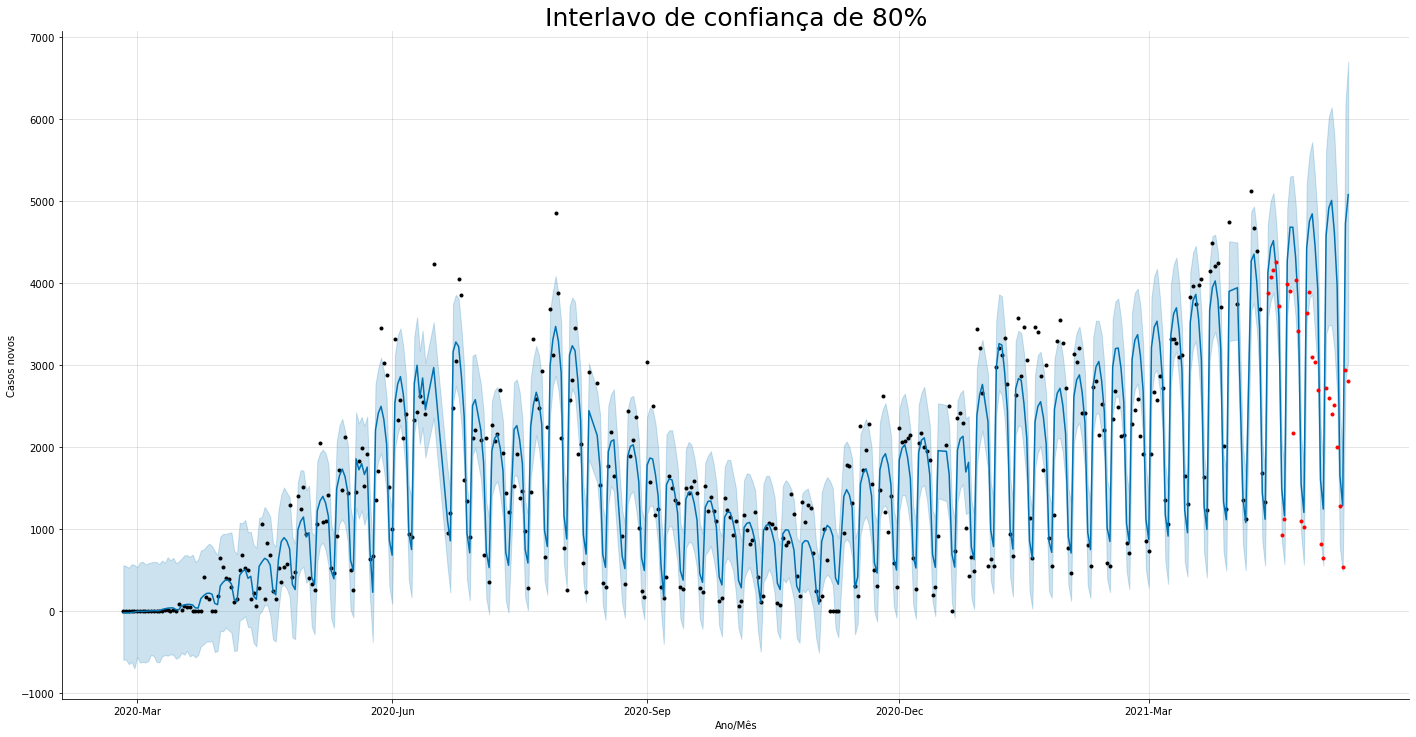

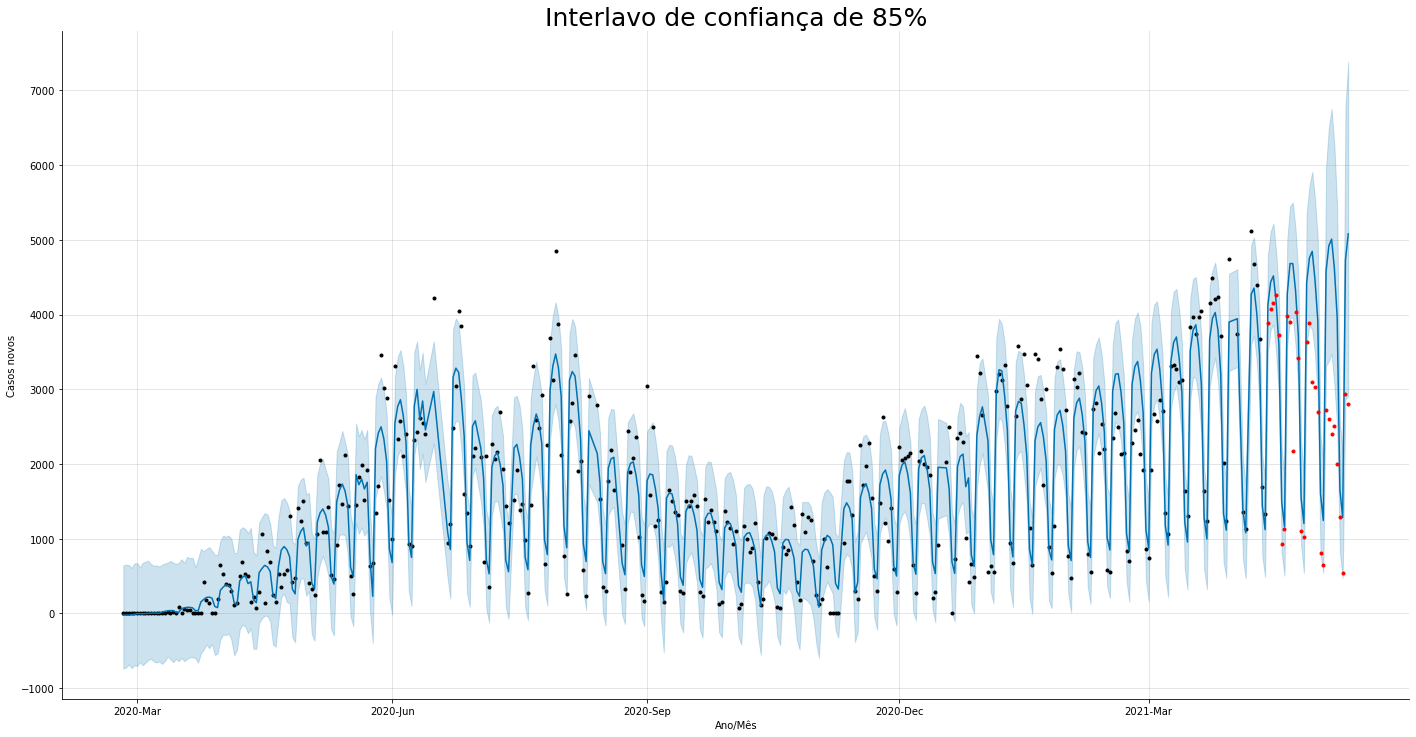

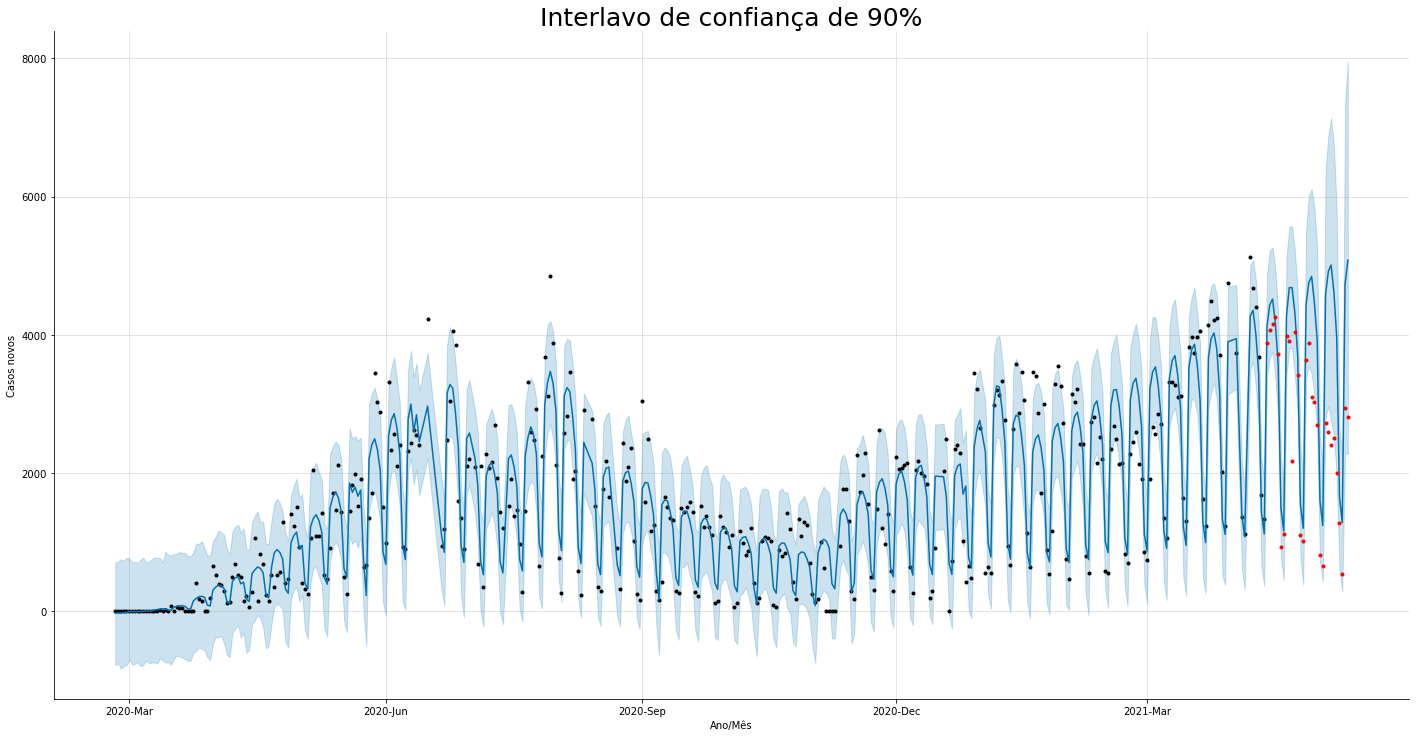

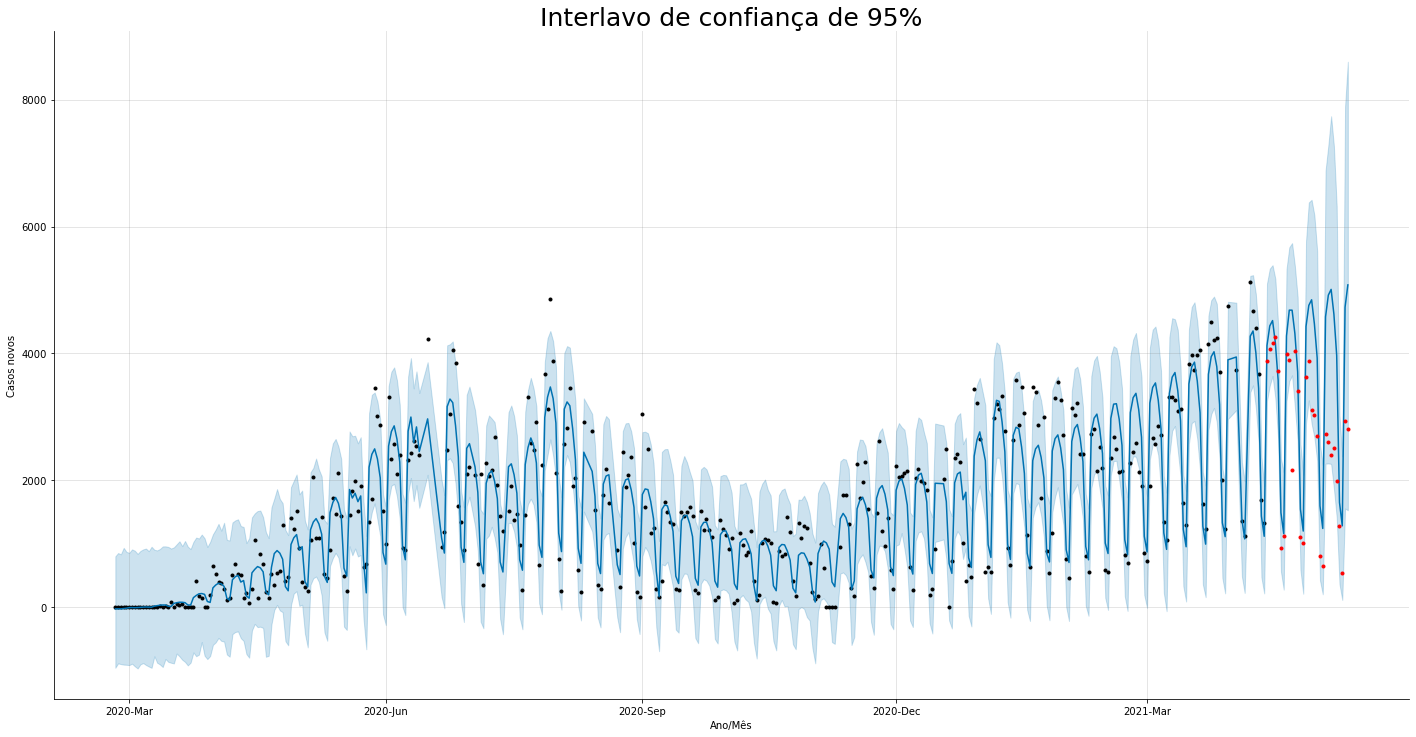

In [44]:
modelos = {}
for i in range(70, 100, 5):
    modelos[str(i)] = Modelo_prophet_semanal(df_sem_outliers.append(modelo_com_outliers.teste), changepoint_prior_scale=10, seasonality_mode='multiplicative', holidays=feriados, interval_width=i/100)
    fig = modelos[str(i)].plota(xlabel='Ano/Mês', ylabel='Casos novos', kwargs_testeplot={'marker':'.', 'color':'red'})
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(f'Interlavo de confiança de {i}%', fontsize=25)

## Desafio 14: Buscar quais métricas se aplicam a quais casos.